## Chapter12.2: Predicting Time Sequences

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置plt中汉字显示

In [2]:
# 定义常用函数
def plotSeries(timeline, values, title = '', start=0, end=-1, singlegraph=True):
    '''绘图'''
    if singlegraph: plt.figure(figsize=(10,6))
    plt.plot(timeline[start:end], values[start:end])
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

def checkError(test, predict):
    '''计算并展示预测和测试集的误差'''
    print('均方误差:', keras.metrics.mean_squared_error(test, predict).numpy())
    print('平均绝对误差:', keras.metrics.mean_absolute_error(test, predict).numpy())

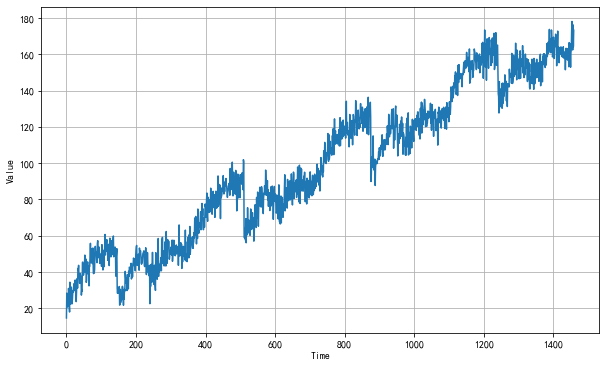

In [3]:
preiod = 365
repeat_time = 4
time = np.arange(preiod*repeat_time+1)

# Step1: 生成主要的上升趋势和基准线
slope = 0.1
baseline = 20

# Step2: 生成季节性的时间序列
def seasonality(time, period, amplitud=0, phase=0):
    interval = ((time+phase)%period)/period
    return amplitud*np.where(interval<0.4, np.tanh(interval*2*np.pi)**0.6, 1/np.exp(2*interval)*np.sin(interval*25))

# Step3: 生成噪音
def noise(time, amplifer=1):
    return np.random.randn(len(time))*amplifer

# 结合总体趋势，周期变化，噪声和基准线
series = baseline + time * slope + seasonality(time, period=365, amplitud=20) + noise(time, amplifer=5) 
plotSeries(time, series) 

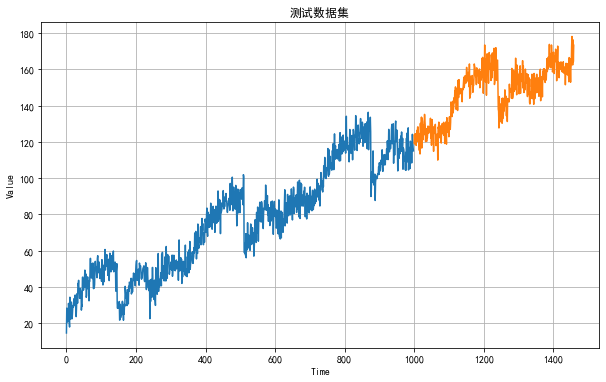

In [4]:
# 划分数据集
train_size = 1000
train_time = time[:train_size]
train_values = series[:train_size]
test_time = time[train_size:]
test_values = series[train_size:]

plotSeries(train_time, train_values, '训练数据集')
plotSeries(test_time, test_values, '测试数据集', singlegraph=False)

## 朴素预测（Naive Forecast）

In [5]:
naive_forecast = series[train_size - 1: -1]

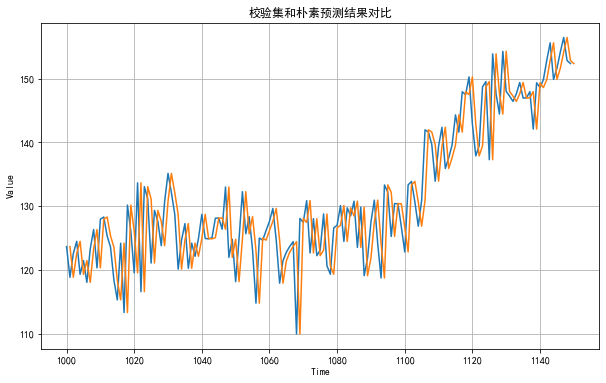

In [6]:
plotSeries(test_time, test_values, end=150)
plotSeries(test_time, naive_forecast, '校验集和朴素预测结果对比', 1, 151, False)
# 清晰看出，校验集和预测集存在一个相差

In [7]:
checkError(test_values,naive_forecast)

均方误差: 51.06228870774052
平均绝对误差: 5.6363072049418665


## 移动平均（moving average）

In [8]:
def movingAverageForecast(values, window_size):
    """Forecasts the mean of last few values.
       If window_size=1, then this is equvialent to navie forecast"""
    tmp = values.copy()
    for i in range(1,len(tmp)):
        tmp[i] += tmp[i-1]
    return np.array([(tmp[time+window_size]-tmp[time])/window_size for time in range(len(tmp) - window_size)])

    # or

    # return np.array([series[time:time+window_size].mean() for time in range(len(series)-window_size)])

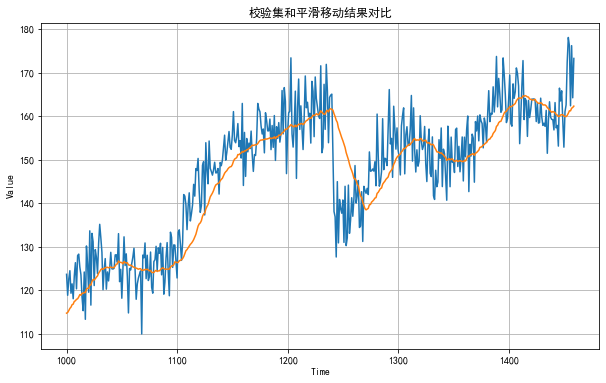

In [9]:
moving_average_forecast = movingAverageForecast(series, 30)[train_size-30:]
plotSeries(test_time, test_values)
plotSeries(test_time, moving_average_forecast, title='校验集和平滑移动结果对比', singlegraph=False)

In [10]:
checkError(test_values,moving_average_forecast)

均方误差: 50.08267916308333
平均绝对误差: 5.4781429101745776


进行整体平均移动后，误差甚至要比朴素预测还要高，原因是：周期和噪声一起平均移动，相互干扰

接下来分离趋势和噪声，只对噪声进行平滑移动

## 部分移动平均 （partly moving average）
相位相同的情况下（不同周期，同样的位置），值是相同。于是，噪声就可以通过减去上个周期的同相位的值得到

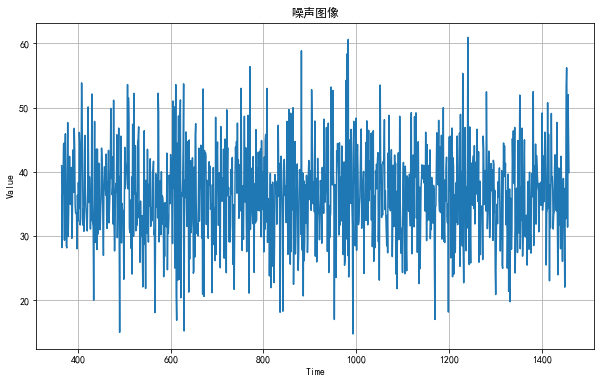

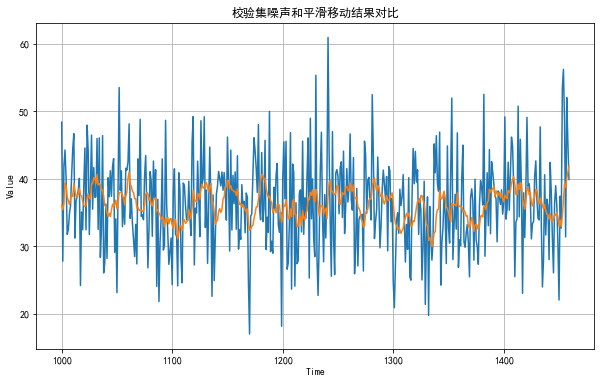

In [17]:
# 移除周期性
diff_series = (series[preiod:] - series[:-preiod])
diff_time = time[preiod:]
plotSeries(diff_time, diff_series, '噪声图像')

# 校验集平滑移动结果
diff_moving_avg = movingAverageForecast(diff_series, 10)[train_size-preiod-10:]
plotSeries(test_time, diff_series[train_size-preiod:])
plotSeries(test_time, diff_moving_avg, '校验集噪声和平滑移动结果对比', singlegraph=False)

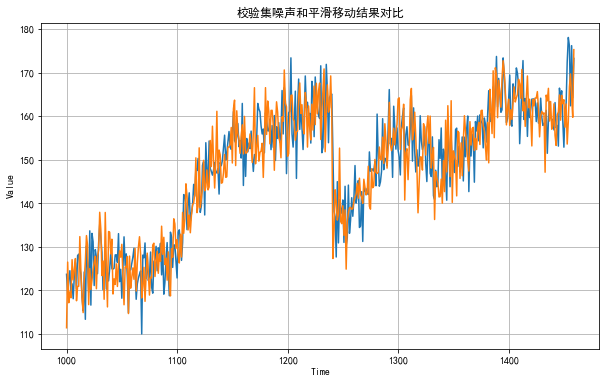

In [18]:
# 获取周期性的数值，和平滑移动的噪声合并
partly_moving_average_forecast = diff_moving_avg + series[train_size-preiod:-preiod]
plotSeries(test_time, test_values)
plotSeries(test_time, partly_moving_average_forecast, '校验集噪声和平滑移动结果对比', singlegraph=False)

In [19]:
checkError(test_values, partly_moving_average_forecast)

均方误差: 41.81399821430745
平均绝对误差: 5.191327450208868
